# Introduction
This notebook classifies tweets based on their sentiment.

# Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import re
import string

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
nlp = spacy.load('en_core_web_sm')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-12-23 00:20:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-12-23 00:22:55 (5.17 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [3]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [4]:
train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', index_col=0, header=None, names=['entity', 'label', 'text'])
test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', index_col=0, header=None, names=['entity', 'label', 'text'])

# Data preprocessing

In [5]:
def lowercase(data):
    return data['text'].str.lower()

def change_punctuation(data):
    return data['text'].str.replace('`', "'")

def remove_numbers(data):
    return data['text'].replace('[^a-zA-z.,!?/:;\"\'\s]', '', regex=True)

def remove_special_characters(data):
    return data['text'].replace('[^a-zA-Z0-9 ]', '', regex=True)

def custom(data):
    return data['text'].replace('im', 'i am')
    
def lemmatize(data):
    lemmatized_array = []
    
    for text in data['text']:
        lemmatized_text = []
        doc = nlp(text)
        for token in doc:
            lemmatized_text.append(token.lemma_)
        lemmatized_array.append(' '.join(lemmatized_text))
    return lemmatized_array

def stop_words(data):
    stop_words_array = []
    for text in data['text']:
        doc = nlp(text)
        filtered_tokens = [token.text for token in doc if not token.is_stop]
        stop_words_array.append(' '.join(filtered_tokens))
    return stop_words_array

def delete_links(data):
    return data['text'].replace(r'http\S+', '', regex=True)

def preprocessing(data):
    df = data.copy()
    df['text'] = lowercase(df)
    df['text'] = custom(df)
    df['text'] = change_punctuation(df)
    df['text'] = lemmatize(df)
    df['text'] = remove_numbers(df)
    df['text'] = delete_links(df)
    df['text'] = remove_special_characters(df)
    return df

In [6]:
train.drop_duplicates(subset=['text'], inplace=True)
train.reset_index(inplace=True)
train['text'] = train['text'].astype('str')
test['text'] = test['text'].astype('str')

In [7]:
train = preprocessing(train)
test = preprocessing(test)

In [8]:
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])
test['label'] = le.transform(test['label'])

X = train['text']
y = train['label']

# Data splitting

In [9]:
max_words = 10000
maxlen = 200
emb_dim = 50
training_samples = int(len(X)*0.8)

text_dataset = tf.data.Dataset.from_tensor_slices(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Text Vectorization

In [10]:
max_features = 20000
embedding_dim = 128

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_words,
        output_mode='int',
        output_sequence_length=maxlen
        )

vectorize_layer.adapt(text_dataset.batch(64))  

In [11]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Embedding

In [12]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8305 words (1695 misses)


In [13]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

# Model

In [14]:
model = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
cl = [tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy',
                  restore_best_weights=True,
                  patience=10)] 

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=64, callbacks = cl)

Epoch 1/50
869/869 [==============================] - 36s 40ms/step - loss: 1.3207 - accuracy: 0.3786 - val_loss: 1.2132 - val_accuracy: 0.4820
Epoch 2/50
869/869 [==============================] - 35s 40ms/step - loss: 1.2095 - accuracy: 0.4759 - val_loss: 1.1236 - val_accuracy: 0.5251
Epoch 3/50
869/869 [==============================] - 35s 40ms/step - loss: 1.1365 - accuracy: 0.5197 - val_loss: 1.0936 - val_accuracy: 0.5470
Epoch 4/50
869/869 [==============================] - 34s 39ms/step - loss: 1.0837 - accuracy: 0.5483 - val_loss: 1.0412 - val_accuracy: 0.5644
Epoch 5/50
869/869 [==============================] - 35s 40ms/step - loss: 1.0230 - accuracy: 0.5790 - val_loss: 0.9979 - val_accuracy: 0.5864
Epoch 6/50
869/869 [==============================] - 35s 40ms/step - loss: 0.9598 - accuracy: 0.6072 - val_loss: 0.9737 - val_accuracy: 0.5995
Epoch 7/50
869/869 [==============================] - 34s 39ms/step - loss: 0.9092 - accuracy: 0.6319 - val_loss: 0.9554 - val_accuracy:

# Evaluation

<Axes: >

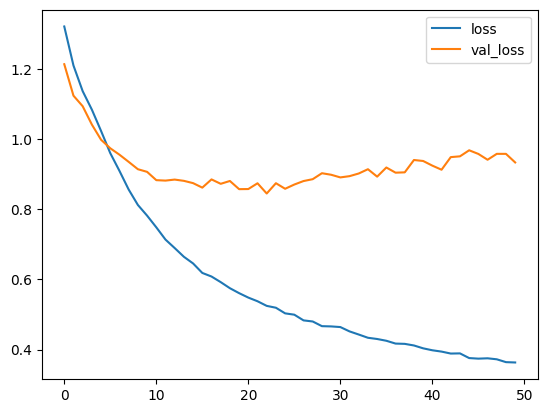

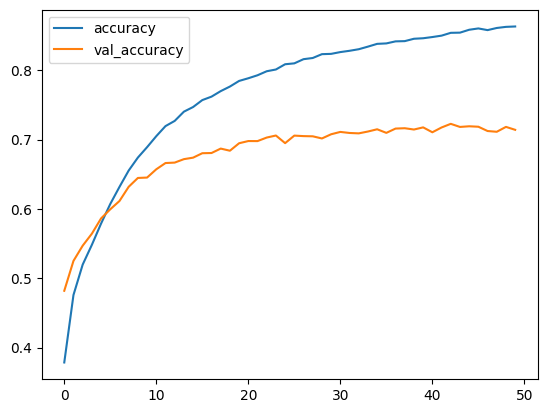

In [16]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [17]:
predictions = model.predict(test['text'])

32/32 [==============================] - 0s 7ms/step


In [18]:
test['label'] = le.fit_transform(test['label'])

In [19]:
predicted_labels = []

for predictions_array in predictions:
    predicted_labels.append(np.argmax(predictions_array))

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(predicted_labels, test['label'])

0.905